In [1]:
%matplotlib inline

In [2]:
import os
import pickle
import sys
from collections import Counter, defaultdict
from copy import deepcopy
from itertools import combinations
import pandas as pd
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw
from joblib import Parallel, delayed
from matplotlib import colors
from networkx.algorithms.community.quality import modularity as nx_modularity
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils.testing import ignore_warnings
from tqdm.notebook import tqdm


sys.path.append('../../pygkernels')
from pygkernels.measure import kernels
from pygkernels.scenario import d3_colors

/home/illusionww/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Functions

In [3]:
def create_krondecker(partition):
    n = len(partition)
    kron_mask = np.tile(partition, n) == np.repeat(partition, n)
    return np.reshape(kron_mask, (n, n))

def modularity2(AIJ, partition):
    n = len(AIJ)
    m = np.sum(AIJ)  # no of edges

    k = np.sum(AIJ, axis=1)
    expectation = np.reshape(np.tile(k, n) * np.repeat(k, n), (n, n)) / m
    kron = create_krondecker(partition)

    # Q = (1 / 2m) * SUM(AIJ - (ki.kj / 2m)) ∂(ci, cj)
    return (1.0 / m) * np.sum(kron * (AIJ - expectation))

In [4]:
def np2nx(A: np.ndarray, partition: np.ndarray):
    G = nx.from_numpy_matrix(A)
    nx.set_node_attributes(G, dict(enumerate(partition)), 'community')
    return G

def partition2communities(partition):
    result = defaultdict(list)
    for idx, class_ in enumerate(partition):
        result[class_].append(idx)
    return list(result.values())

def estimate_mu(graph, partition):
    n_out_edges = 0
    n_nodes = graph.size()
    for n1, n2 in graph.edges():  # links:
        if partition[n1] != partition[n2]:
            n_out_edges += 1
    return n_out_edges / n_nodes

def power_law(values, maxval=200):
    tau = powerlaw.Fit(values, verbose=False).alpha
    if tau > maxval or np.isnan(tau):
        tau = maxval
    return tau

def redetect_params(data):
    A, partition = data['A'], data['y_true']
    G = np2nx(A, partition)
    
    n = G.number_of_nodes()
    average_degree = 2 * G.number_of_edges() / n
    node_degrees = [d for n, d in G.degree()]
    min_degree = np.min(node_degrees)
    max_degree = np.max(node_degrees)
    tau1 = power_law(node_degrees, 250)
    modularity = nx_modularity(G, partition2communities(partition))

    # Community-based parameters
    k = len(set(partition))
    mu = min(max(estimate_mu(G, partition), 0.), 1.)
    community_sizes = list(Counter(partition).values())
    min_community = np.min(community_sizes)
    max_community = np.max(community_sizes)
    tau2 = power_law(community_sizes, 250)
    
    return {
        'n': n,
        'k': k,
        'average_degree': average_degree,
        'min_degree': min_degree, 
        'max_degree': max_degree,
        'tau1': tau1,
        'mu': mu,
        'min_community': min_community,
        'max_community': max_community,
        'tau2': tau2,
        'modularity': modularity
    }

In [5]:
class MyKNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        for test_idx in range(len(X_test)):
            chosen_indices = np.argsort(pair_distance[test_idx])[:self.n_neighbors]
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            for chosen_idx in chosen_indices:
                weighted_results += self.y[chosen_idx]
            output.append(weighted_results)
        return np.array(output)
    

def euclidean_distances(X, Y):
    X, Y = np.array(X), np.array(Y)
    result = np.sqrt(np.sum(np.power(X[:, None] - Y[None, :], 2), axis=2))
    return result


class MyGaussianFilter:
    def __init__(self, sigma=0.05):
        self.sigma = sigma
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def predict(self, X_test):
        output = []
        pair_distance = euclidean_distances(X_test, self.X)
        gaussian_weights = np.exp(-np.power(pair_distance, 2) / (2 * self.sigma**2))
        for test_idx in range(len(X_test)):
            chosen_indices = []
            for train_idx in range(len(self.X)):
                if pair_distance[test_idx, train_idx] < 3 * self.sigma:
                    chosen_indices.append(train_idx)
            if len(chosen_indices) < 3:
                chosen_indices = []
            weighted_results = np.zeros(len(self.y[0]), dtype=np.float32)
            sum_weights = np.sum([gaussian_weights[test_idx, chosen_idx] for chosen_idx in chosen_indices])
            for chosen_idx in chosen_indices:
                weighted_results += gaussian_weights[test_idx, chosen_idx] * self.y[chosen_idx] / sum_weights
            output.append(weighted_results)
        return np.array(output)

In [6]:
def prepare_plot_knn(dataset, feature_names, n_neighbors=1):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([sorted(item[0].items(), key=lambda x: -x[1])[0][0] for item in dataset])
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernel_name = knn.predict([[xval, yval]])[0] 
            plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            
    return X, y, plot

def prepare_plot_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)

    plot = np.zeros((resolution, resolution, 3), dtype=np.uint8)
    for xidx, xval in enumerate(np.linspace(limits[feature_names[0]][0], limits[feature_names[0]][1], resolution)):
        for yidx, yval in enumerate(np.linspace(limits[feature_names[1]][0], limits[feature_names[1]][1], resolution)):
            pixels_kernels_results = knn.predict([[xval, yval]])[0] 
            if ~np.all(pixels_kernels_results == 0):
                pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
                plot[xidx, yidx] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
            else:
                plot[xidx, yidx] = np.array([1, 1, 1]) * 255
            
    return X, y, plot

In [7]:
def point2plot(x, feature_name):
    vmin, vmax = limits[feature_name]
    return (x - vmin) / (vmax - vmin) * resolution

In [8]:
def doplot(ax, X, y, plot, feature_names, scatter=True):
    ax.imshow(plot)
        
    n_ticks = 10 if feature_names[1] not in ['tau1', 'tau2'] else 2 
    ax.set_xticks(np.linspace(0, resolution, n_ticks))
    ax.set_xticklabels([f'{x:.2f}' for x in np.linspace(real_limits[feature_names[1]][0], real_limits[feature_names[1]][1], n_ticks)], rotation='vertical');
    ax.set_xlabel(feature_names[1])
    ax.set_xlim(0, resolution)
    
    n_ticks = 10 if feature_names[0] not in ['tau1', 'tau2'] else 2 
    ax.set_yticks(np.linspace(0, resolution, n_ticks))
    ax.set_yticklabels([f'{x:.2f}' for x in np.linspace(real_limits[feature_names[0]][0], real_limits[feature_names[0]][1], n_ticks)]);
    ax.set_ylabel(feature_names[0])
    ax.set_ylim(0, resolution)

    if scatter:
        ax.scatter([point2plot(x, feature_names[1]) for x in X[:, 1]], [point2plot(x, feature_names[0]) for x in X[:, 0]], s=1, c='black')

In [9]:
def prepare_field_filter(dataset, feature_names, distance=0.05):
    X = np.array([[fnc[fname](item[1][fname]) for fname in feature_names] for item in dataset])
    y = np.array([[item[0][kernel] for kernel in kernels_order] for item in dataset])
    
    knn = MyGaussianFilter(sigma=distance)
    knn.fit(X, y)
    
    arr = np.zeros([resolution] * len(feature_names) + [y.shape[1]], dtype=np.float32)
    plot = np.zeros([resolution] * len(feature_names) + [3], dtype=np.uint8)
    params_spaces = [np.linspace(limits[fname][0], limits[fname][1], resolution) for fname in feature_names]
    print(params_spaces)
    for point in tqdm(product(*[range(resolution) for _ in range(len(feature_names))]), total=resolution ** len(feature_names)):
        params = [params_spaces[i][point[i]] for i in range(len(feature_names))]
        pixels_kernels_results = knn.predict([params])[0]
        arr[point] = pixels_kernels_results
        
        if ~np.all(pixels_kernels_results == 0):
            pixels_kernel_name = kernels_order[np.argmax(pixels_kernels_results)]
            plot[point] = np.array(colors.to_rgb(d3_colors[pixels_kernel_name])) * 255
        else:
            plot[point] = np.array([1, 1, 1]) * 255
    
    return X, y, arr, plot

In [10]:
class RFE:
    def __init__(self, estimator, names, max_features=5, n_jobs=None):
        self.estimator = estimator
        self.names = names
        self.max_features = max_features
        self.n_jobs = n_jobs
        self.results = {}

    @ignore_warnings(category=ConvergenceWarning)
    def score_one(self, x, y, weights, set_feat_names):
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)

        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        if np.max(y) == 1:
            y_pred = estimator.predict_proba(x[:, support])
            y_pred = y_pred[:, 1] > 0.5
        else:
            y_pred = estimator.predict(x[:, support])
        f1 = f1_score(y, y_pred)
        return set_feat_names, f1, estimator

    def fit(self, x, y, weights):
        # for all features first:
        _, f1_all, estimator_all = self.score_one(x, y, weights, self.names)
        print(f'all features, f1={f1_all:.3f}')

        for n_features in range(1, self.max_features + 1):
            results = Parallel(n_jobs=self.n_jobs)(
                delayed(self.score_one)(x, y, weights, set_feat_names)
                for set_feat_names in list(combinations(self.names, n_features)))
            best_n_feat, best_f1, best_estimator = None, 0, None
            for set_feat_names, f1, estimator in results:
                if f1 > best_f1:
                    best_n_feat, best_f1, best_estimator = set_feat_names, f1, estimator
            print(f'{n_features} features, f1={best_f1:.3f}, set={best_n_feat}')
            if hasattr(best_estimator, 'best_params_'):
                print(best_estimator.best_params_)
            self.results[n_features] = {
                'f1': best_f1,
                'set': best_n_feat
            }
        return self

    def draw1d(self, x, y, weights):
        set_feat_names = self.results[1]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(1, 2, figsize=(16, 3))
        ax[0].scatter(x[:, support_idx[0]], [np.random.rand() for _ in range(x.shape[0])], c=ty_bool)
        ax[0].set_title('gt')
        ax[1].scatter(x[:, support_idx[0]], [np.random.rand() for _ in range(x.shape[0])], c=y_pred)
        ax[1].set_title('preds')

        ax[0].set_xlabel(set_feat_names[0])
        ax[1].set_xlabel(set_feat_names[0])

        plt.tight_layout()
    
    def draw2d(self, x, y, weights):
        set_feat_names = self.results[2]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=ty_bool)
        ax[0].set_title('gt')
        ax[1].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=y_pred)
        ax[1].set_title('preds')

        ax[0].set_xlabel(set_feat_names[0])
        ax[1].set_xlabel(set_feat_names[0])
        ax[0].set_ylabel(set_feat_names[1])
        ax[1].set_ylabel(set_feat_names[1])

        plt.tight_layout()
        
    def draw3d(self, x, y, weights):
        set_feat_names = self.results[3]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(2, 2, figsize=(16, 16))
        ax[0][0].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=ty_bool)
        ax[0][0].set_title('gt')
        ax[0][1].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=y_pred)
        ax[0][1].set_title('preds')

        ax[0][0].set_xlabel(set_feat_names[0])
        ax[0][1].set_xlabel(set_feat_names[0])
        ax[0][0].set_ylabel(set_feat_names[1])
        ax[0][1].set_ylabel(set_feat_names[1])
        
        ax[1][0].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=ty_bool)
        ax[1][0].set_title('gt')
        ax[1][1].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=y_pred)
        ax[1][1].set_title('preds')

        ax[1][0].set_xlabel(set_feat_names[1])
        ax[1][1].set_xlabel(set_feat_names[1])
        ax[1][0].set_ylabel(set_feat_names[2])
        ax[1][1].set_ylabel(set_feat_names[2])

        plt.tight_layout()
        
    def draw4d(self, x, y, weights):
        set_feat_names = self.results[4]['set']
        print(set_feat_names)
        support = np.array([x in set_feat_names for x in self.names], dtype=np.bool)
        print(support)
        support_idx = [x for x in range(support.shape[0]) if support[x]]
        print(support_idx)
        
        estimator = deepcopy(self.estimator)
        if weights != None:
            estimator.fit(x[:, support], y, sample_weight=weights)
        else:
            estimator.fit(x[:, support], y)
        y_pred = estimator.predict_proba(x[:, support])[:, 1]
        f1 = f1_score(y, y_pred > 0.5)
        
        print(f'f1: {f1:.3f}')

        fig, ax = plt.subplots(3, 2, figsize=(16, 24))
        ax[0][0].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=ty_bool)
        ax[0][0].set_title('gt')
        ax[0][1].scatter(x[:, support_idx[0]], x[:, support_idx[1]], c=y_pred)
        ax[0][1].set_title('preds')

        ax[0][0].set_xlabel(set_feat_names[0])
        ax[0][1].set_xlabel(set_feat_names[0])
        ax[0][0].set_ylabel(set_feat_names[1])
        ax[0][1].set_ylabel(set_feat_names[1])
        
        ax[1][0].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=ty_bool)
        ax[1][0].set_title('gt')
        ax[1][1].scatter(x[:, support_idx[1]], x[:, support_idx[2]], c=y_pred)
        ax[1][1].set_title('preds')

        ax[1][0].set_xlabel(set_feat_names[1])
        ax[1][1].set_xlabel(set_feat_names[1])
        ax[1][0].set_ylabel(set_feat_names[2])
        ax[1][1].set_ylabel(set_feat_names[2])

        ax[2][0].scatter(x[:, support_idx[2]], x[:, support_idx[3]], c=ty_bool)
        ax[2][0].set_title('gt')
        ax[2][1].scatter(x[:, support_idx[2]], x[:, support_idx[3]], c=y_pred)
        ax[2][1].set_title('preds')

        ax[2][0].set_xlabel(set_feat_names[2])
        ax[2][1].set_xlabel(set_feat_names[2])
        ax[2][0].set_ylabel(set_feat_names[3])
        ax[2][1].set_ylabel(set_feat_names[3])

        plt.tight_layout()

# Prepare data

In [11]:
import datetime
print(datetime.datetime.now())

2020-09-17 10:56:35.623400


In [12]:
resolution = 100

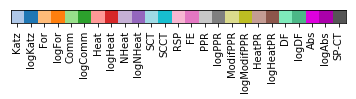

In [13]:
a = np.zeros((1, 25, 3), dtype=np.uint8)
labels = []
for idx, kernel in enumerate(kernels):
    a[0, idx] = np.array(colors.to_rgb(d3_colors[kernel.name])) * 255
    labels.append(kernel.name)
plt.imshow(a)
plt.xticks(range(25), labels, rotation='vertical')
plt.yticks([]);

In [14]:
root = '/media/illusionww/68949C3149F4E819/phd/pygkernels/montecarlo_lfr'
    
def perform_one(fn):
    with open(f'{root}/{fn}', 'rb') as f:
        data = pickle.load(f)
    need_to_save = False
    A = data['A']
    item = {}
    for kernel_name, kernel_results in data['results'].items():
        kernel_best_ari = -1
        for parameter, parameter_results in kernel_results.items():
            if len(parameter_results) > 0:
                if 'new_modularity2' not in parameter_results[0]:  # add new_modularity if not exist
                    for init_idx, init in enumerate(parameter_results):
                        partition = init['labels']
                        init['new_modularity2'] = modularity2(A, partition)
                    need_to_save = True
                param_best_ari = sorted(parameter_results, key=lambda x: -x['new_modularity2'])[0]['score_ari']
                kernel_best_ari = max(kernel_best_ari, param_best_ari)
        item[kernel_name] = kernel_best_ari
    
    if need_to_save:
        with open(f'{root}/{fn}', 'wb') as f:
            pickle.dump(data, f)
    
    return item, redetect_params(data)

dataset = Parallel(n_jobs=12)(delayed(perform_one)(fn) for fn in tqdm(os.listdir(root)))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [15]:
# generate additional features
for item in dataset:
    maxari = np.max(list(item[0].values()))
    item[1]['maxari'] = maxari
    item[1]['density'] = item[1]['average_degree'] / (item[1]['n'] - 1)
    item[1]['min_community/max_community'] = item[1]['min_community'] / item[1]['max_community']
    item[1]['min_degree/max_degree'] = item[1]['min_degree'] / item[1]['max_degree']
    item[1]['mu/density'] = item[1]['mu'] / item[1]['density']

In [16]:
with open('all_dataset.json', 'w') as f:
    json.dump([{k: float(v) for k, v in x[1].items()} for x in dataset], f)

In [17]:
all_feature_names = [
    'n',
    'k',
    'tau1',
    'tau2',
    'mu',
    'average_degree',
    'min_community',
    'maxari',
    'modularity',
    'density',
    'min_community/max_community',
    'min_degree/max_degree',
    'mu/density'
]

feature_inv = lambda x, power: (1 - (1 / x**power))
feature_normalize = lambda x, fn: x

fnc = {
    'n': lambda x: feature_normalize(x, 'n'),
    'k': lambda x: feature_normalize(feature_inv(x, 1), 'k'),
    'tau1': lambda x: feature_normalize(feature_inv(x, 0.5), 'tau1'),
    'tau2': lambda x: feature_normalize(feature_inv(x, 0.5), 'tau2'),
    'mu': lambda x: feature_normalize(x, 'mu'),
    'average_degree': lambda x: feature_normalize(x, 'average_degree'),
    'min_community': lambda x: feature_normalize(x, 'min_community'),
    'maxari': lambda x: feature_normalize(x, 'maxari'),
    'modularity': lambda x: feature_normalize(x, 'modularity'),
    'density': lambda x: feature_normalize(x, 'density'),
    'min_community/max_community': lambda x: feature_normalize(x, 'min_community/max_community'),
    'min_degree/max_degree': lambda x: feature_normalize(x, 'min_degree/max_degree'),
    'mu/density': lambda x: feature_normalize(x, 'mu/density')
}

feature_mins = {fn: np.min([fnc[fn](info[fn]) for _, info in dataset]) for fn in all_feature_names}
feature_width = {fn: np.max([fnc[fn](info[fn]) for _, info in dataset]) - np.min([fnc[fn](info[fn]) for _, info in dataset]) for fn in all_feature_names}
feature_normalize = lambda x, fn: (x - feature_mins[fn]) / feature_width[fn]


In [18]:
real_limits = {}
limits = {}
for fname in all_feature_names:
    min_max = np.min([info[fname] for _, info in dataset]), np.max([info[fname] for _, info in dataset])
    real_limits[fname] = min_max
    limits[fname] = fnc[fname](min_max[0]), fnc[fname](min_max[1])
    print(f'{fname}: {real_limits[fname][0]:.2f}, {real_limits[fname][1]:.2f} | {limits[fname][0]:.2f}, {limits[fname][1]:.2f}')

n: 10.00, 1499.00 | 0.00, 1.00
k: 2.00, 224.00 | 0.00, 1.00
tau1: 1.87, 250.00 | 0.00, 1.00
tau2: 1.51, 250.00 | 0.00, 1.00
mu: 0.00, 1.00 | 0.00, 1.00
average_degree: 1.17, 954.59 | 0.00, 1.00
min_community: 1.00, 749.00 | 0.00, 1.00
maxari: 0.00, 1.00 | 0.00, 1.00
modularity: -0.50, 0.95 | 0.00, 1.00
density: 0.00, 0.81 | 0.00, 1.00
min_community/max_community: 0.01, 1.00 | 0.00, 1.00
min_degree/max_degree: 0.00, 0.88 | 0.00, 1.00
mu/density: 0.00, 419.60 | 0.00, 1.00


In [19]:
kernels_order = [x.name for x in kernels]
list(enumerate(kernels_order))

[(0, 'Katz'),
 (1, 'logKatz'),
 (2, 'For'),
 (3, 'logFor'),
 (4, 'Comm'),
 (5, 'logComm'),
 (6, 'Heat'),
 (7, 'logHeat'),
 (8, 'NHeat'),
 (9, 'logNHeat'),
 (10, 'SCT'),
 (11, 'SCCT'),
 (12, 'RSP'),
 (13, 'FE'),
 (14, 'PPR'),
 (15, 'logPPR'),
 (16, 'ModifPPR'),
 (17, 'logModifPPR'),
 (18, 'HeatPR'),
 (19, 'logHeatPR'),
 (20, 'DF'),
 (21, 'logDF'),
 (22, 'Abs'),
 (23, 'logAbs'),
 (24, 'SP-CT')]

# Hist density

In [20]:
items = []
for _, info in dataset:
    n = info['n'] / 1500
    tau1 = 1 - (1 / info['tau1']**0.5)
    tau2 = 1 - (1 / info['tau2']**0.5)
    mu = info['mu']
    average_degree = info['average_degree'] / 850
    items.append([n, tau1, tau2, mu, average_degree])

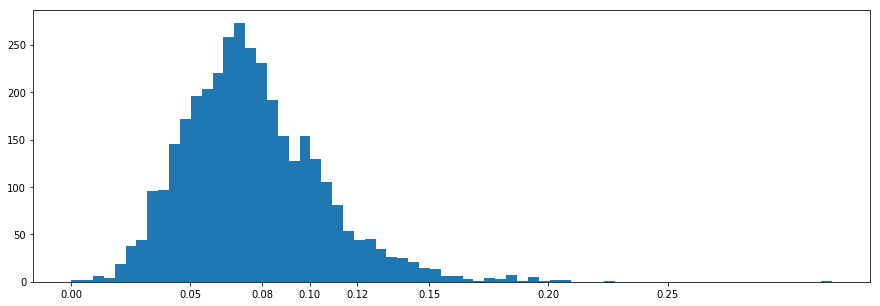

In [21]:
distances = euclidean_distances(items, items)
np.fill_diagonal(distances, 9999)
min_distances = np.min(distances, axis=0)
plt.subplots(1, figsize=(15, 5))
plt.hist(min_distances, bins=70);
plt.xticks(ticks=[0, 0.05, 0.08, 0.1, 0.12, 0.15, 0.20, 0.25]);

# Select features

# Draw images

In [22]:
dataset_wo_scct = deepcopy(dataset)
for idx in range(len(dataset)):
    for measure_name in dataset_wo_scct[idx][0].keys():
        if measure_name == 'SCCT':
            dataset_wo_scct[idx][0][measure_name] = 0

top6 = ['SCCT', 'NHeat', 'logComm', 'SCT', 'RSP', 'Comm']
dataset_top6 = deepcopy(dataset)
for idx in range(len(dataset)):
    for measure_name in dataset_top6[idx][0].keys():
        if measure_name not in top6:
            dataset_top6[idx][0][measure_name] = 0
            
top5 = ['NHeat', 'logComm', 'SCT', 'RSP', 'Comm']
dataset_top5 = deepcopy(dataset)
for idx in range(len(dataset)):
    for measure_name in dataset_top5[idx][0].keys():
        if measure_name not in top5:
            dataset_top5[idx][0][measure_name] = 0

was_deleted = True
while was_deleted:
    was_deleted = False
    for idx in range(len(dataset_wo_scct)):
        if np.sum(np.max(list(dataset_wo_scct[idx][0].values())) == list(dataset_wo_scct[idx][0].values())) > 1:
            del dataset_wo_scct[idx]
            was_deleted = True
            break
            
was_deleted = True
while was_deleted:
    was_deleted = False
    for idx in range(len(dataset_top6)):
        if np.sum(np.max(list(dataset_top6[idx][0].values())) == list(dataset_top6[idx][0].values())) > 1:
            del dataset_top6[idx]
            was_deleted = True
            break

was_deleted = True
while was_deleted:
    was_deleted = False
    for idx in range(len(dataset_top5)):
        if np.sum(np.max(list(dataset_top5[idx][0].values())) == list(dataset_top5[idx][0].values())) > 1:
            del dataset_top5[idx]
            was_deleted = True
            break

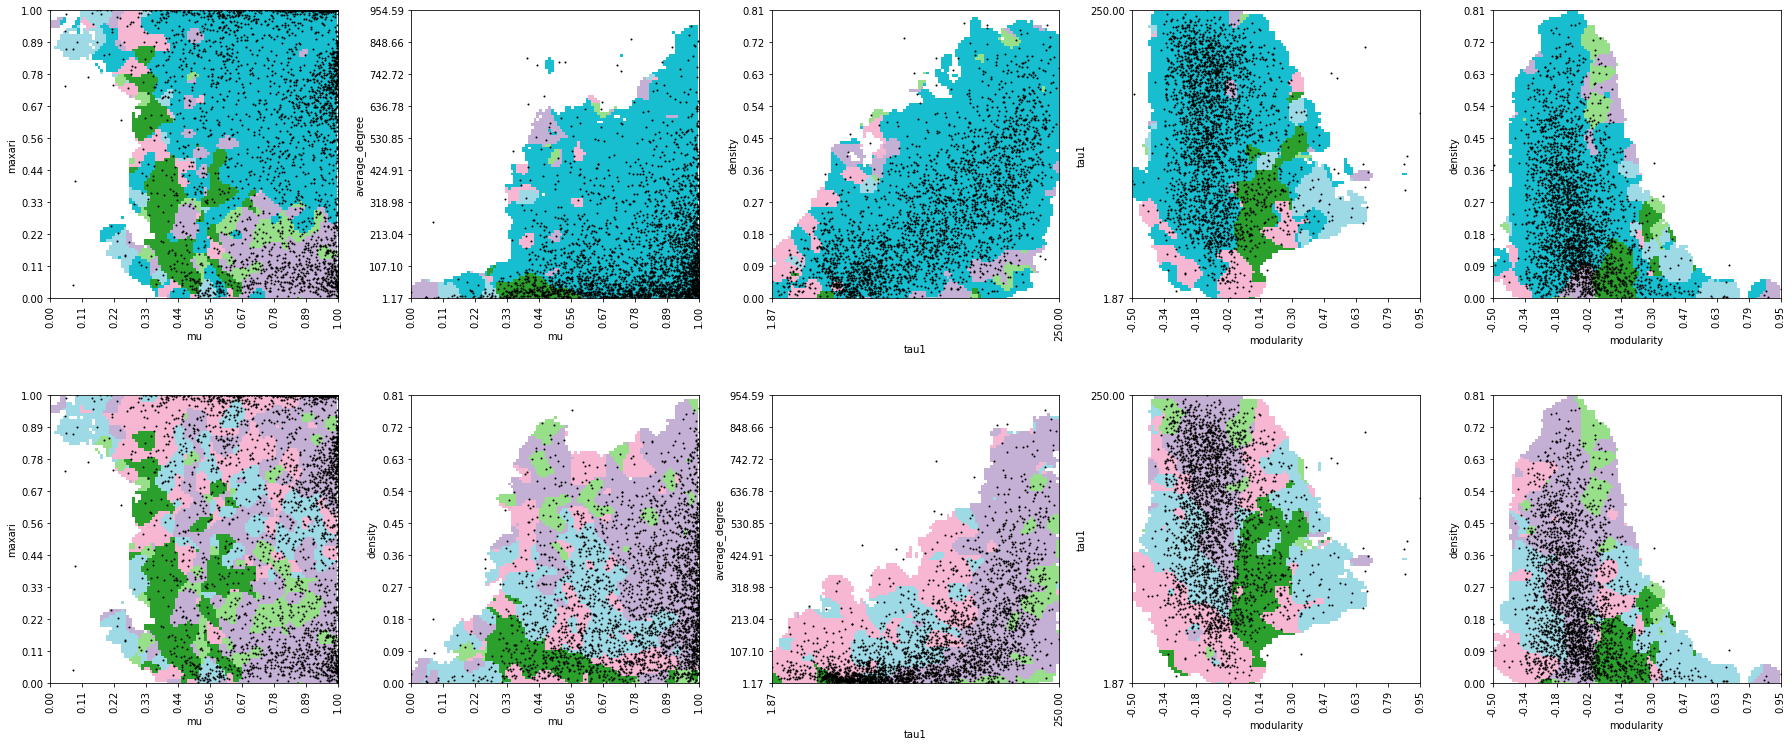

In [23]:
distance = 0.02

fig, ax = plt.subplots(2, 5, figsize=(25, 11))

feature_names = ['maxari', 'mu']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['average_degree', 'mu']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['density', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['tau1', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][3], X, y, plot, feature_names)

feature_names = ['density', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][4], X, y, plot, feature_names)


feature_names = ['maxari', 'mu']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['density', 'mu']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['average_degree', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['tau1', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][3], X, y, plot, feature_names)

feature_names = ['density', 'modularity']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][4], X, y, plot, feature_names)


plt.tight_layout()

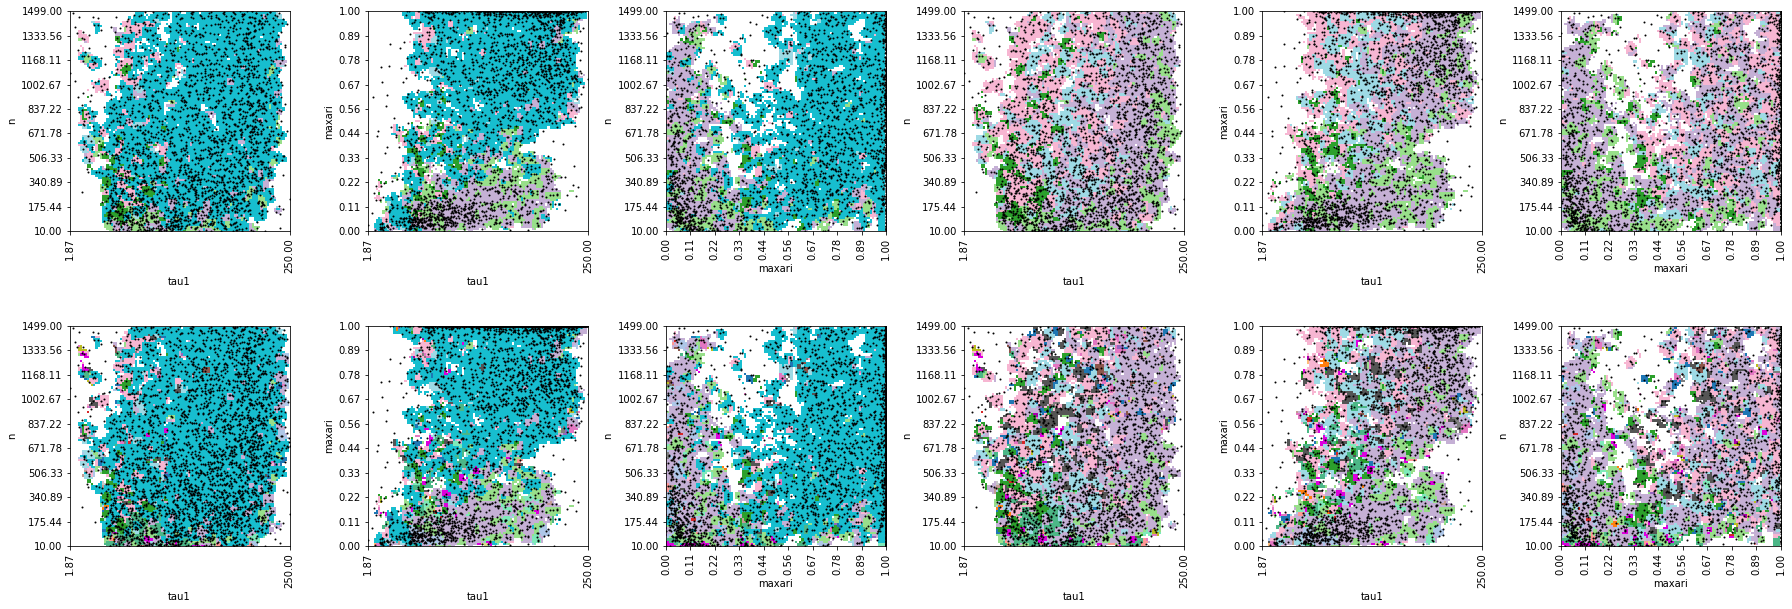

In [24]:
distance = 0.01

fig, ax = plt.subplots(2, 6, figsize=(25, 9))

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[0][3], X, y, plot, feature_names)

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[0][4], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[0][5], X, y, plot, feature_names)


feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_wo_scct, feature_names, distance=distance)
doplot(ax[1][3], X, y, plot, feature_names)

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset_wo_scct, feature_names, distance=distance)
doplot(ax[1][4], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_wo_scct, feature_names, distance=distance)
doplot(ax[1][5], X, y, plot, feature_names)


plt.tight_layout()

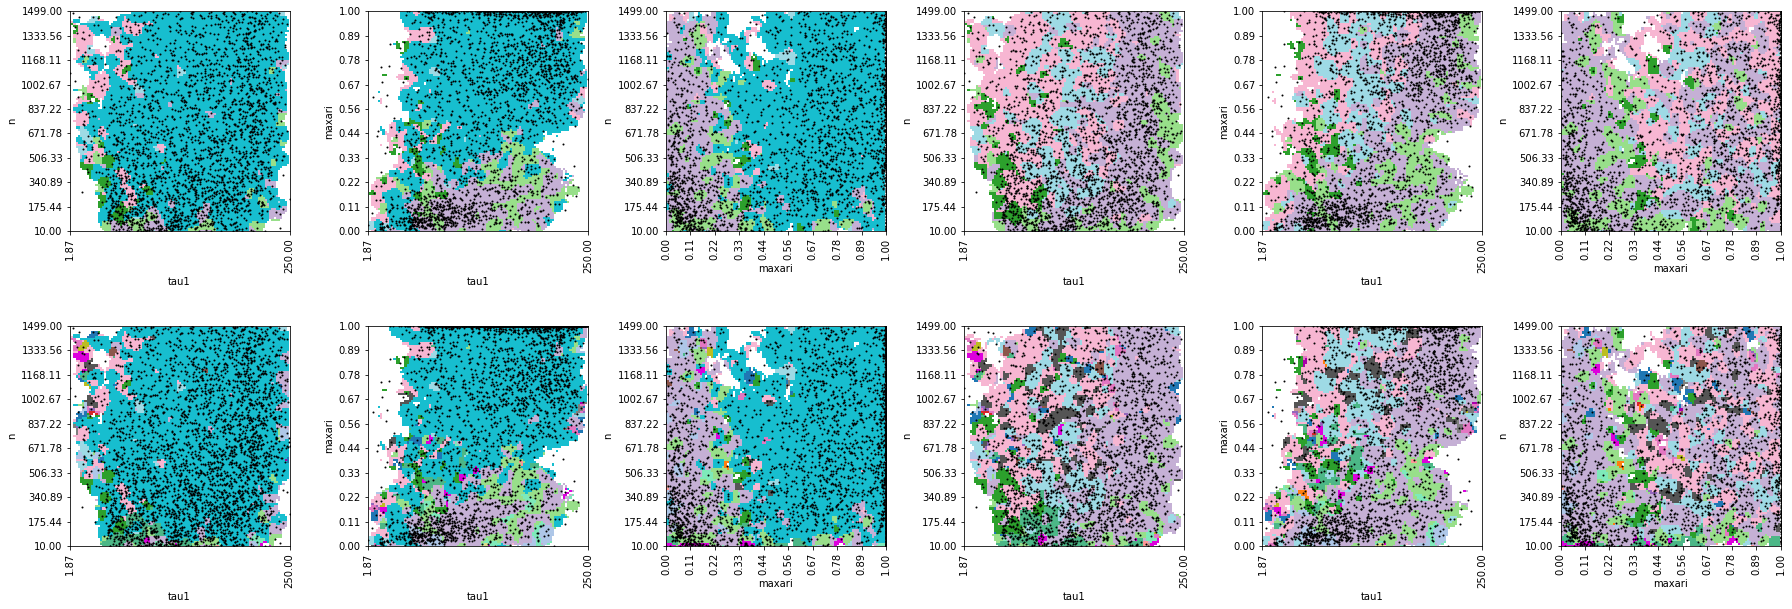

In [25]:
distance = 0.015

fig, ax = plt.subplots(2, 6, figsize=(25, 9))

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[0][3], X, y, plot, feature_names)

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[0][4], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[0][5], X, y, plot, feature_names)


feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_wo_scct, feature_names, distance=distance)
doplot(ax[1][3], X, y, plot, feature_names)

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset_wo_scct, feature_names, distance=distance)
doplot(ax[1][4], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_wo_scct, feature_names, distance=distance)
doplot(ax[1][5], X, y, plot, feature_names)


plt.tight_layout()

In [26]:
dataset_top6_modularity_0, dataset_top6_modularity_1, dataset_top6_modularity_2, dataset_top6_modularity_3, dataset_top6_modularity_4 = [], [], [], [], []
for idx in range(len(dataset_top6)):
    tau1 = point2plot(fnc['maxari'](dataset_top6[idx][1]['maxari']), 'maxari') / resolution
    if 0 <= tau1 < 0.2:
        dataset_top6_modularity_0.append(dataset_top6[idx])
    elif 0.2 <= tau1 < 0.4:
        dataset_top6_modularity_1.append(dataset_top6[idx])
    elif 0.4 <= tau1 < 0.6:
        dataset_top6_modularity_2.append(dataset_top6[idx])
    elif 0.6 <= tau1 < 0.8:
        dataset_top6_modularity_3.append(dataset_top6[idx])
    elif 0.8 <= tau1 <= 1:
        dataset_top6_modularity_4.append(dataset_top6[idx])
print(len(dataset_top6_modularity_0), len(dataset_top6_modularity_1), len(dataset_top6_modularity_2), len(dataset_top6_modularity_3), len(dataset_top6_modularity_4))
        
dataset_top5_modularity_0, dataset_top5_modularity_1, dataset_top5_modularity_2, dataset_top5_modularity_3, dataset_top5_modularity_4 = [], [], [], [], []
for idx in range(len(dataset_top5)):
    tau1 = point2plot(fnc['maxari'](dataset_top5[idx][1]['maxari']), 'maxari') / resolution
    if 0 <= tau1 < 0.2:
        dataset_top5_modularity_0.append(dataset_top5[idx])
    elif 0.2 <= tau1 < 0.4:
        dataset_top5_modularity_1.append(dataset_top5[idx])
    elif 0.4 <= tau1 < 0.6:
        dataset_top5_modularity_2.append(dataset_top5[idx])
    elif 0.6 <= tau1 < 0.8:
        dataset_top5_modularity_3.append(dataset_top5[idx])
    elif 0.8 <= tau1 <= 1:
        dataset_top5_modularity_4.append(dataset_top5[idx])
print(len(dataset_top5_modularity_0), len(dataset_top5_modularity_1), len(dataset_top5_modularity_2), len(dataset_top5_modularity_3), len(dataset_top5_modularity_4))

721 281 290 543 907
721 281 291 543 955


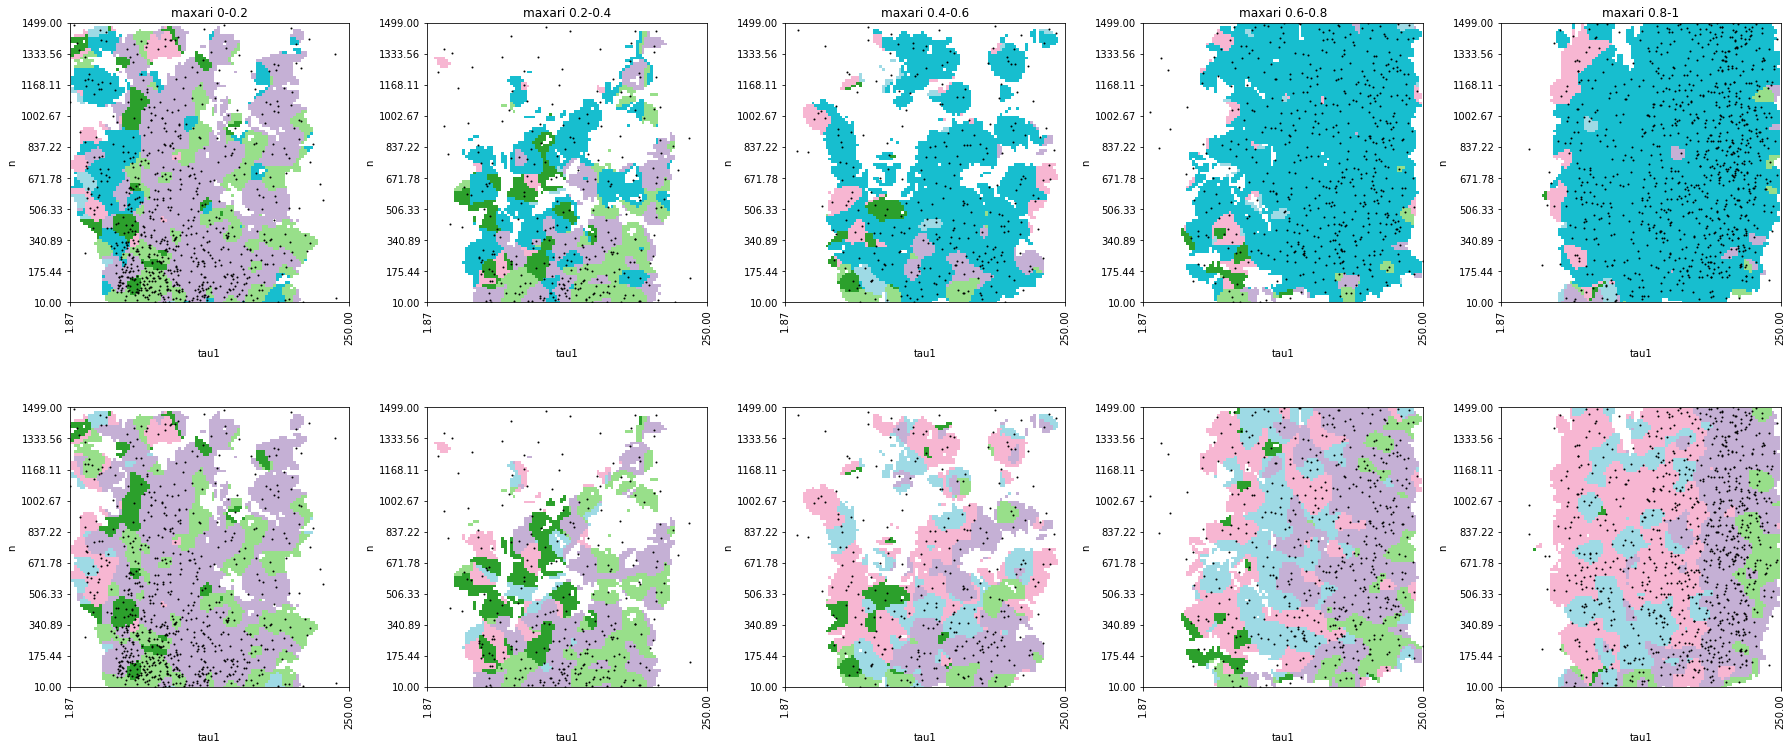

In [27]:
distance = 0.02

fig, ax = plt.subplots(2, 5, figsize=(25, 11))

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_0, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)
ax[0][0].set_title('maxari 0-0.2')

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_1, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)
ax[0][1].set_title('maxari 0.2-0.4')

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_2, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)
ax[0][2].set_title('maxari 0.4-0.6')

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_3, feature_names, distance=distance)
doplot(ax[0][3], X, y, plot, feature_names)
ax[0][3].set_title('maxari 0.6-0.8')

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_4, feature_names, distance=distance)
doplot(ax[0][4], X, y, plot, feature_names)
ax[0][4].set_title('maxari 0.8-1')


feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_0, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_1, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_2, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_3, feature_names, distance=distance)
doplot(ax[1][3], X, y, plot, feature_names)

feature_names = ['n', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_4, feature_names, distance=distance)
doplot(ax[1][4], X, y, plot, feature_names)


plt.tight_layout()

In [28]:
dataset_top6_modularity_0, dataset_top6_modularity_1, dataset_top6_modularity_2, dataset_top6_modularity_3, dataset_top6_modularity_4 = [], [], [], [], []
for idx in range(len(dataset_top6)):
    tau1 = point2plot(fnc['tau1'](dataset_top6[idx][1]['tau1']), 'tau1') / resolution
    if 0 <= tau1 < 0.2:
        dataset_top6_modularity_0.append(dataset_top6[idx])
    elif 0.2 <= tau1 < 0.4:
        dataset_top6_modularity_1.append(dataset_top6[idx])
    elif 0.4 <= tau1 < 0.6:
        dataset_top6_modularity_2.append(dataset_top6[idx])
    elif 0.6 <= tau1 < 0.8:
        dataset_top6_modularity_3.append(dataset_top6[idx])
    elif 0.8 <= tau1 <= 1:
        dataset_top6_modularity_4.append(dataset_top6[idx])
print(len(dataset_top6_modularity_0), len(dataset_top6_modularity_1), len(dataset_top6_modularity_2), len(dataset_top6_modularity_3), len(dataset_top6_modularity_4))
        
dataset_top5_modularity_0, dataset_top5_modularity_1, dataset_top5_modularity_2, dataset_top5_modularity_3, dataset_top5_modularity_4 = [], [], [], [], []
for idx in range(len(dataset_top5)):
    tau1 = point2plot(fnc['tau1'](dataset_top5[idx][1]['tau1']), 'tau1') / resolution
    if 0 <= tau1 < 0.2:
        dataset_top5_modularity_0.append(dataset_top5[idx])
    elif 0.2 <= tau1 < 0.4:
        dataset_top5_modularity_1.append(dataset_top5[idx])
    elif 0.4 <= tau1 < 0.6:
        dataset_top5_modularity_2.append(dataset_top5[idx])
    elif 0.6 <= tau1 < 0.8:
        dataset_top5_modularity_3.append(dataset_top5[idx])
    elif 0.8 <= tau1 <= 1:
        dataset_top5_modularity_4.append(dataset_top5[idx])
print(len(dataset_top5_modularity_0), len(dataset_top5_modularity_1), len(dataset_top5_modularity_2), len(dataset_top5_modularity_3), len(dataset_top5_modularity_4))

168 666 629 743 536
169 676 635 766 545


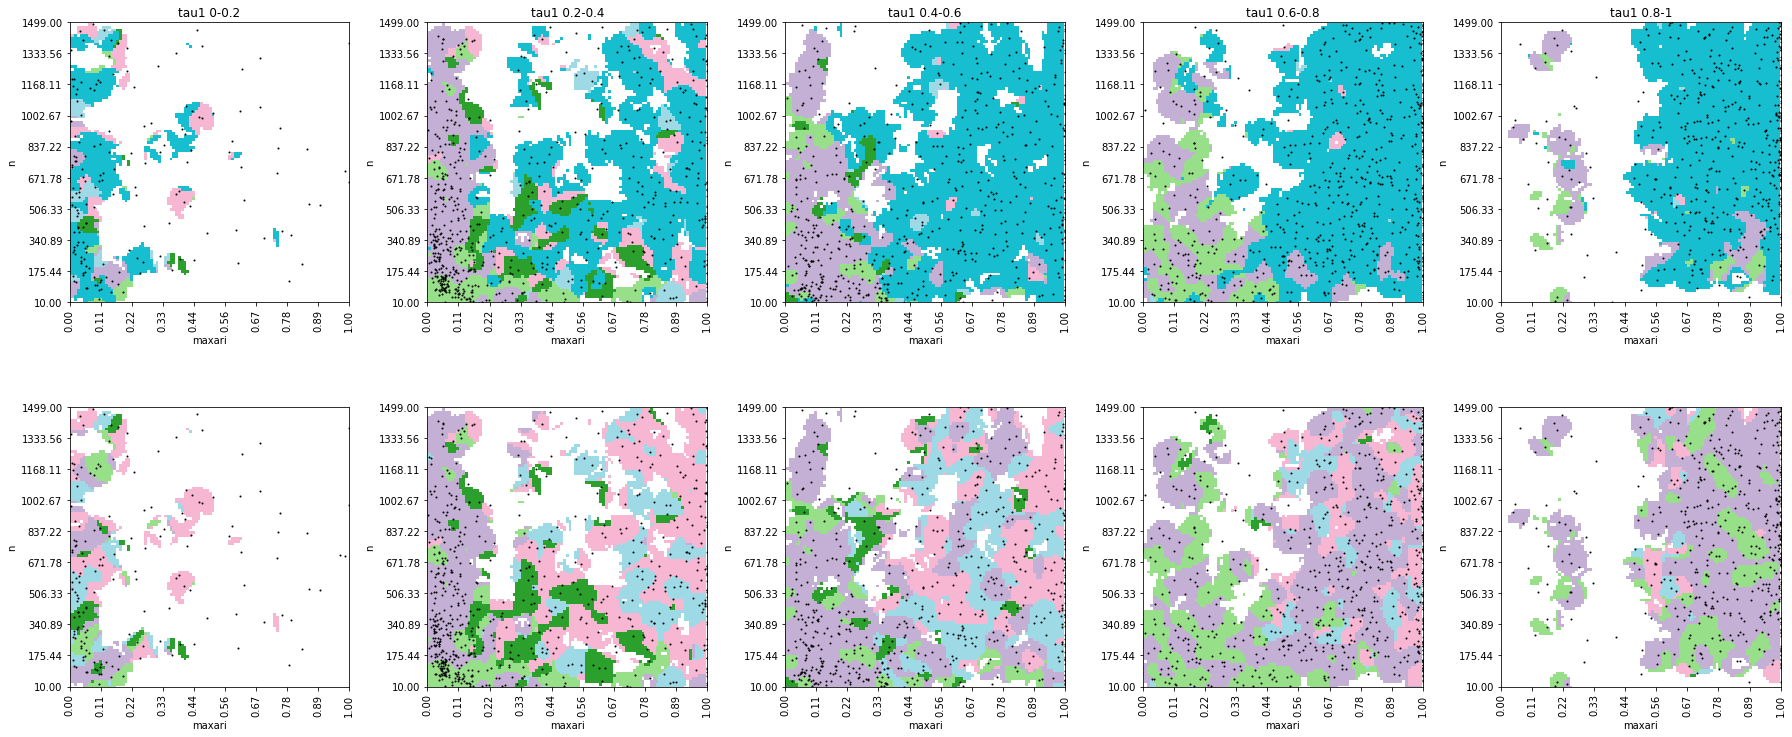

In [29]:
distance = 0.02

fig, ax = plt.subplots(2, 5, figsize=(25, 11))

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_0, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)
ax[0][0].set_title('tau1 0-0.2')

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_1, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)
ax[0][1].set_title('tau1 0.2-0.4')

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_2, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)
ax[0][2].set_title('tau1 0.4-0.6')

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_3, feature_names, distance=distance)
doplot(ax[0][3], X, y, plot, feature_names)
ax[0][3].set_title('tau1 0.6-0.8')

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top6_modularity_4, feature_names, distance=distance)
doplot(ax[0][4], X, y, plot, feature_names)
ax[0][4].set_title('tau1 0.8-1')


feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_0, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_1, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_2, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_3, feature_names, distance=distance)
doplot(ax[1][3], X, y, plot, feature_names)

feature_names = ['n', 'maxari']
X, y, plot = prepare_plot_filter(dataset_top5_modularity_4, feature_names, distance=distance)
doplot(ax[1][4], X, y, plot, feature_names)


plt.tight_layout()

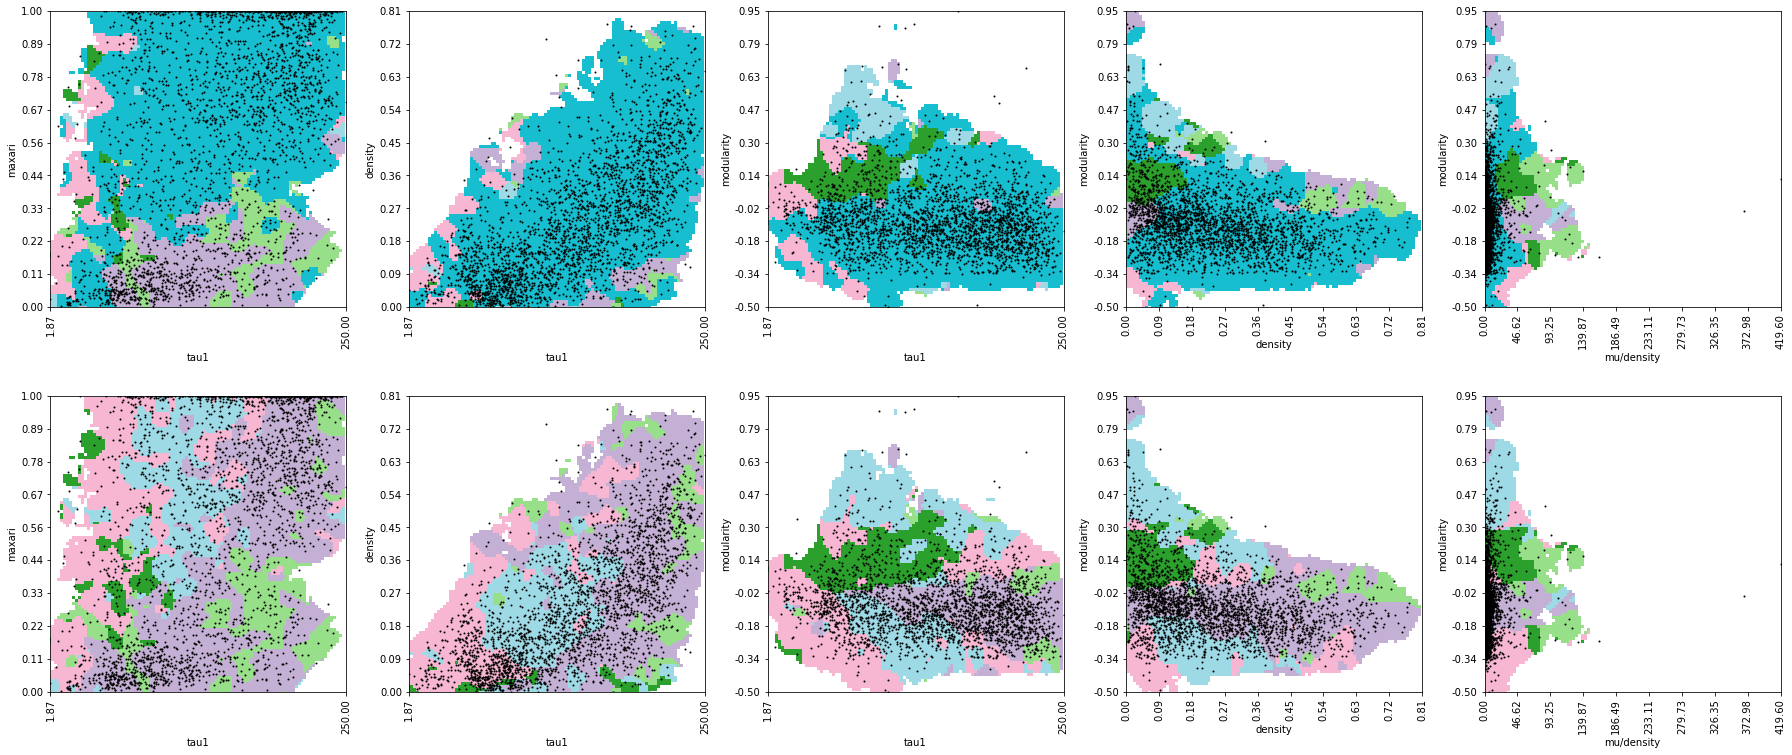

In [30]:
distance = 0.02

fig, ax = plt.subplots(2, 5, figsize=(25, 11))

feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][0], X, y, plot, feature_names)

feature_names = ['density', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][1], X, y, plot, feature_names)

feature_names = ['modularity', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][2], X, y, plot, feature_names)

feature_names = ['modularity', 'density']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][3], X, y, plot, feature_names)

feature_names = ['modularity', 'mu/density']
X, y, plot = prepare_plot_filter(dataset_top6, feature_names, distance=distance)
doplot(ax[0][4], X, y, plot, feature_names)


feature_names = ['maxari', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][0], X, y, plot, feature_names)

feature_names = ['density', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][1], X, y, plot, feature_names)

feature_names = ['modularity', 'tau1']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][2], X, y, plot, feature_names)

feature_names = ['modularity', 'density']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][3], X, y, plot, feature_names)

feature_names = ['modularity', 'mu/density']
X, y, plot = prepare_plot_filter(dataset_top5, feature_names, distance=distance)
doplot(ax[1][4], X, y, plot, feature_names)


plt.tight_layout()

# Retouch / search for best basis